In [ ]:
import os
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from supabase import create_client, Client

# Try to find .env file explicitly
env_path = find_dotenv()
if not env_path:
    print("Warning: .env file not found.")
else:
    load_dotenv(env_path)

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_API_KEY") or os.getenv("SUPABASE_SERVICE_ROLE_KEY")
TABLE = "macro_state_daily"

print(f"Supabase URL: {SUPABASE_URL}")
print(f"Supabase Key found: {bool(SUPABASE_KEY)}")

def fetch_macro_state(start="2000-01-01", end=None):
    if not SUPABASE_URL or not SUPABASE_KEY:
        raise ValueError("Missing SUPABASE_URL or SUPABASE_KEY environment variables.")

    supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
    
    all_rows = []
    offset = 0
    limit = 1000
    
    # Build base query
    query = supabase.table(TABLE).select("*").order("date", desc=False).gte("date", start)
    if end:
        query = query.lte("date", end)

    while True:
        try:
            # Execute query with range for pagination
            response = query.range(offset, offset + limit - 1).execute()
            data = response.data
        except Exception as e:
            print(f"Warning: Request failed at offset {offset}: {e}")
            break

        if not data:
            break
            
        all_rows.extend(data)
        
        if len(data) < limit:
            break
            
        offset += len(data)
    
    if not all_rows:
        return pd.DataFrame()
        
    df = pd.DataFrame(all_rows)
    
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date").sort_index()

    # numeric columns coercion
    num_cols = [
        "stress_score","core_cpi_yoy","core_cpi_yoy_med","orders_yoy","orders_mom","orders_mom_med",
        "unrate_chg_3m","yc_10y2y","hy_oas","stlfsi4","vix","regime_id"
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            
    if "stress_flag" in df.columns:
        df["stress_flag"] = df["stress_flag"].astype(bool)

    return df

try:
    macro = fetch_macro_state(start="2020-01-01")
    print(f"Fetched {len(macro)} rows.")
    display(macro.tail())
except Exception as e:
    print(f"Error fetching data: {e}")

Supabase URL: https://jiutbqmbfwgwfcouvdjv.supabase.co
Supabase Key found: True
Fetched 1000 rows.


,regime_id,regime_label,stress_flag,stress_score,stress_driver,core_cpi_yoy,core_cpi_yoy_med,orders_yoy,orders_mom,orders_mom_med,unrate_chg_3m,yc_10y2y,hy_oas,stlfsi4,vix,updated_at
date,,,,,,,,,,,,,,,,
2003-10-27,1,Goldilocks,False,0.0,none,1.254574,2.460763,5.190537,7423,4498.5,-0.2,2.47,4.80,-0.1064,18.049999,2026-01-22T03:46:07+00:00
2003-10-28,1,Goldilocks,False,0.0,none,1.254574,2.460763,5.190537,7423,4498.5,-0.2,2.52,4.87,-0.1064,16.820000,2026-01-22T03:46:07+00:00
2003-10-29,1,Goldilocks,False,0.0,none,1.254574,2.460763,5.190537,7423,4498.5,-0.2,2.52,4.77,-0.1064,16.430000,2026-01-22T03:46:07+00:00
2003-10-30,1,Goldilocks,False,0.0,none,1.254574,2.460763,5.190537,7423,4498.5,-0.2,2.50,4.68,-0.1064,16.330000,2026-01-22T03:46:07+00:00
2003-10-31,1,Goldilocks,False,0.0,none,1.254574,2.460763,5.190537,7423,4498.5,-0.2,2.48,4.73,-0.2446,16.100000,2026-01-22T03:46:07+00:00


In [15]:
import yfinance as yf
import pandas as pd

if 'macro' in locals() and not macro.empty:
    start = macro.index.min().date().isoformat()
    end = (macro.index.max() + pd.Timedelta(days=1)).date().isoformat()

    print(f"Downloading SPX from {start} to {end}...")
    spx = yf.download("^GSPC", start=start, end=end, progress=False)

    # Fix MultiIndex columns if present (common in recent yfinance)
    if isinstance(spx.columns, pd.MultiIndex):
        # Flatten or select just 'Close'
        if 'Close' in spx.columns.get_level_values(0):
             spx = spx.xs('Close', axis=1, level=0, drop_level=True)
        elif 'Close' in spx.columns:
             spx = spx['Close']

    # Ensure we have a clean series or dataframe with 'Close'
    if isinstance(spx, pd.Series):
        spx = spx.to_frame(name="spx_close")
    elif "Close" in spx.columns:
        spx = spx[["Close"]].rename(columns={"Close": "spx_close"})
    else:
        # If flattening failed or structure is different, try taking the first column
        spx = spx.iloc[:, 0].to_frame(name="spx_close")

    # Fix Timezone Issues: Convert to timezone-naive to match macro data
    if spx.index.tz is not None:
        spx.index = spx.index.tz_localize(None)
    
    spx.index = pd.to_datetime(spx.index)

    # Reindex to Business Days
    idx = pd.date_range(macro.index.min(), macro.index.max(), freq="B")
    spx = spx.reindex(idx).ffill()

    df = macro.reindex(idx).ffill()
    
    # Join
    df = df.join(spx, how="left")
    df["spx_ret"] = df["spx_close"].pct_change()

    print("Join completed.")
    display(df.tail())
else:
    print("Macro data not available. Run previous cell first.")

Join completed.


,regime_id,regime_label,stress_flag,stress_score,stress_driver,core_cpi_yoy,core_cpi_yoy_med,orders_yoy,orders_mom,orders_mom_med,unrate_chg_3m,yc_10y2y,hy_oas,stlfsi4,vix,updated_at,spx_close,spx_ret
2003-10-27,1,Goldilocks,False,0.0,none,1.254574,2.460763,5.190537,7423,4498.5,-0.2,2.47,4.80,-0.1064,18.049999,2026-01-22T03:46:07+00:00,1031.130005,0.002158
2003-10-28,1,Goldilocks,False,0.0,none,1.254574,2.460763,5.190537,7423,4498.5,-0.2,2.52,4.87,-0.1064,16.820000,2026-01-22T03:46:07+00:00,1046.790039,0.015187
2003-10-29,1,Goldilocks,False,0.0,none,1.254574,2.460763,5.190537,7423,4498.5,-0.2,2.52,4.77,-0.1064,16.430000,2026-01-22T03:46:07+00:00,1048.109985,0.001261
2003-10-30,1,Goldilocks,False,0.0,none,1.254574,2.460763,5.190537,7423,4498.5,-0.2,2.50,4.68,-0.1064,16.330000,2026-01-22T03:46:07+00:00,1046.939941,-0.001116
2003-10-31,1,Goldilocks,False,0.0,none,1.254574,2.460763,5.190537,7423,4498.5,-0.2,2.48,4.73,-0.2446,16.100000,2026-01-22T03:46:07+00:00,1050.709961,0.003601


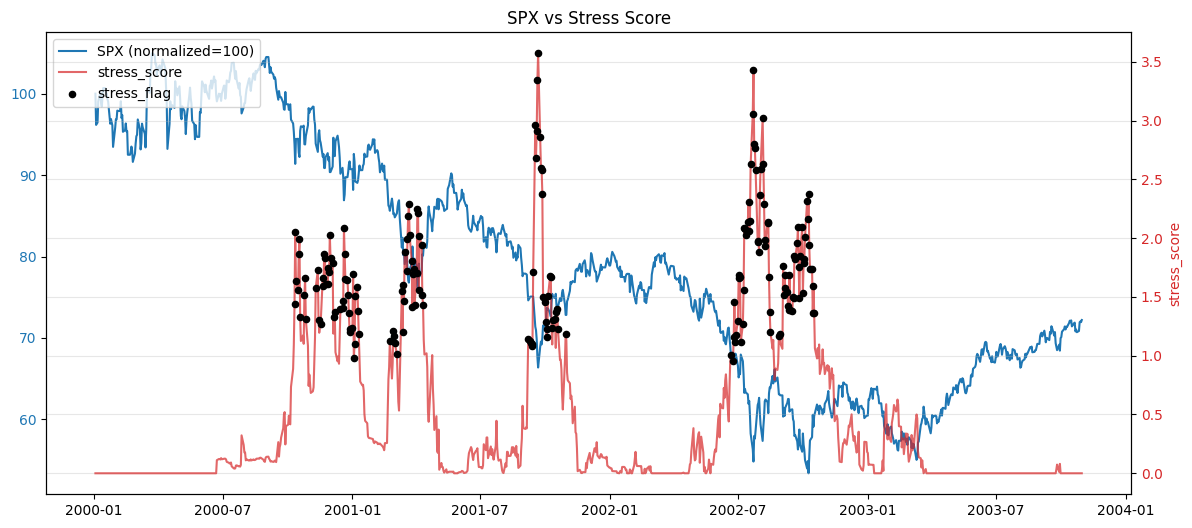

In [16]:
import matplotlib.pyplot as plt
import numpy as np

if 'df' in locals() and not df.empty:
    plot_df = df.dropna(subset=["spx_close"]).copy()
    if not plot_df.empty:
        plot_df["spx_norm"] = 100.0 * (plot_df["spx_close"] / plot_df["spx_close"].iloc[0])

        fig, ax1 = plt.subplots(figsize=(14,6))

        ax1.plot(plot_df.index, plot_df["spx_norm"], label="SPX (normalized=100)", color="tab:blue")
        ax1.set_ylabel="SPX (normalized)"
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(plot_df.index, plot_df["stress_score"], label="stress_score", color="tab:red", alpha=0.7)
        ax2.set_ylabel("stress_score", color="tab:red")
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # stress_flag 찍기(있으면)
        if "stress_flag" in plot_df.columns:
            flagged = plot_df["stress_flag"].fillna(False)
            if flagged.any():
                ax2.scatter(plot_df.index[flagged], plot_df.loc[flagged, "stress_score"], s=20, color="black", label="stress_flag", zorder=5)

        # 범례 합치기
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1+lines2, labels1+labels2, loc="upper left")

        ax1.set_title("SPX vs Stress Score")
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No data to plot after dropping NaNs in spx_close.")
else:
    print("DataFrame 'df' not found. Please run the join cell first.")

/var/folders/np/8l99b0912p3fwzdjm_cp_2t00000gn/T/ipykernel_78876/63552726.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  plot_df['regime_label'] = plot_df['regime_label'].fillna(method='ffill').fillna(method='bfill')


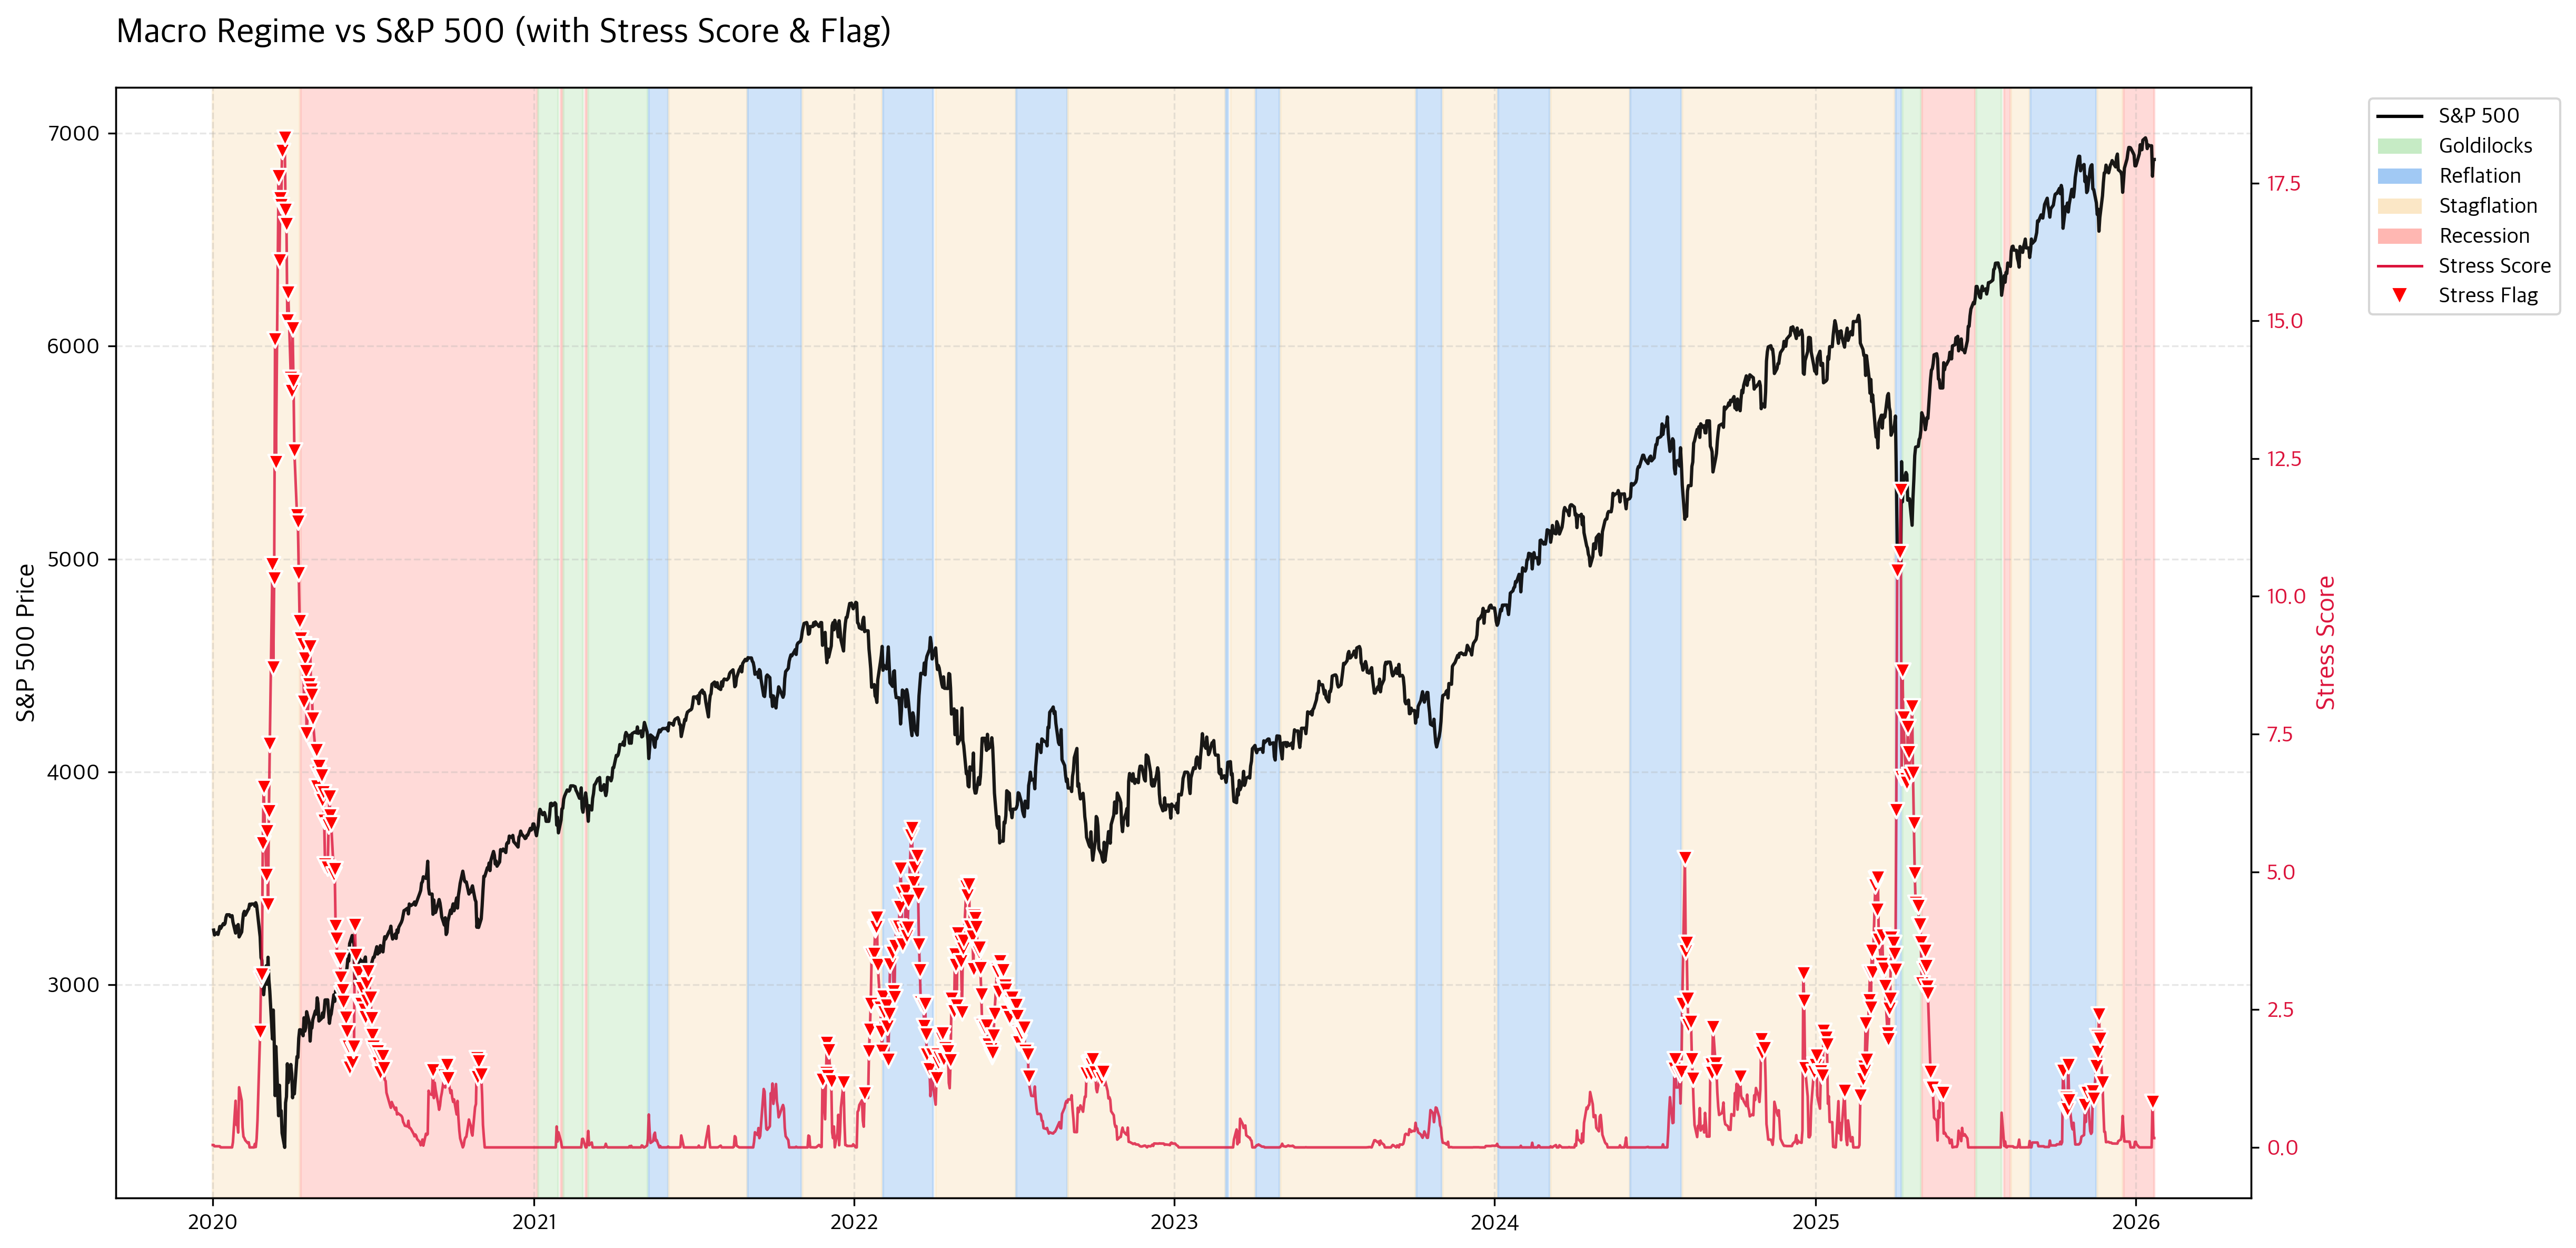

In [5]:
import matplotlib.pyplot as plt
import numpy as np

if 'df' in locals() and not df.empty:
    # Prepare data
    plot_df = df.copy()
    plot_df['regime_label'] = plot_df['regime_label'].fillna(method='ffill').fillna(method='bfill')
    
    # Regime Colors
    regime_colors = {
        'Goldilocks': '#C6EBC5',   # Light Green
        'Reflation': '#A1C9F4',    # Light Blue
        'Stagflation': '#FBE7C6',  # Light Orange/Yellow
        'Recession': '#FFB7B2'     # Light Red
    }
    
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    # 1. Background Regimes
    plot_df['regime_group'] = (plot_df['regime_label'] != plot_df['regime_label'].shift()).cumsum()
    for _, group_data in plot_df.groupby('regime_group'):
        regime = group_data['regime_label'].iloc[0]
        if regime in regime_colors:
            ax1.axvspan(group_data.index.min(), group_data.index.max(), 
                        color=regime_colors[regime], alpha=0.5)
    
    # 2. S&P 500 (Left Axis)
    ax1.plot(plot_df.index, plot_df['spx_close'], color='black', linewidth=1.5, label='S&P 500', alpha=0.9)
    ax1.set_ylabel('S&P 500 Price', fontsize=12, color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # 3. Stress Score (Right Axis)
    if 'stress_score' in plot_df.columns:
        ax2 = ax1.twinx()
        ax2.plot(plot_df.index, plot_df['stress_score'], color='crimson', linewidth=1.2, linestyle='-', label='Stress Score', alpha=0.8)
        ax2.set_ylabel('Stress Score', fontsize=12, color='crimson')
        ax2.tick_params(axis='y', labelcolor='crimson')
        
        # 4. Stress Flag markers
        if 'stress_flag' in plot_df.columns:
            # Highlight stress flags
            flags = plot_df[plot_df['stress_flag'] == 1]
            if not flags.empty:
                # Place markers on the Stress Score line
                ax2.scatter(flags.index, flags['stress_score'], 
                           color='red', marker='v', s=50, label='Stress Flag', edgecolor='white', zorder=10)

    # Customize Title and Layout
    plt.title('Macro Regime vs S&P 500 (with Stress Score & Flag)', fontsize=16, pad=20, loc='left')
    fig.tight_layout()
    
    # Legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    legend_elements = [
        Patch(facecolor=color, edgecolor='none', label=label) for label, color in regime_colors.items()
    ]
    legend_elements.insert(0, Line2D([0], [0], color='black', lw=1.5, label='S&P 500'))
    legend_elements.append(Line2D([0], [0], color='crimson', lw=1.2, label='Stress Score'))
    legend_elements.append(Line2D([0], [0], marker='v', color='w', markerfacecolor='red', label='Stress Flag', markersize=8))
    
    # Combine legends
    ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
    
    plt.show()
else:
    print("Dataframe 'df' missing or empty.")